Below installations might be required

In [19]:
!pip install -U nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# PLEASE RESTART RUNTIME BEFORE AFTER DOWNLOAD FOR METEOR_SCORE FUNCTION TO WORK!

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 4.2 MB/s 
     |████████████████████████████████| 749 kB 63.7 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [1]:
#import necessary packages

import torch
import numpy as np

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import nltk

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# switch to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# open google drive

from google.colab import drive
drive.mount('/gdrive')

%cd/gdrive/My Drive/Colab Notebooks

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks


In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# function to remove punctuation

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [64]:
# read txt files in

with open('files_1_4.txt','r') as infile:
    training_files_1to4 = infile.read()
    tranining_data_ascii = unicodeToAscii(training_files_1to4.lower())
    training_data = tranining_data_ascii.strip().split('end recipe') # a list where each element is a recipe unit
    training_data = training_data[:-1] # pop last item in the list as it is an empty item

with open('dev_files_10_14.txt','r') as infile:
    dev_files_10to17 = infile.read()
    dev_data_ascii = unicodeToAscii(dev_files_10to17.lower())
    dev_data = dev_data_ascii.strip().split('end recipe') # a list where each element is a recipe unit
    dev_data = dev_data[:-1] # pop last item in the list as it is an empty item

with open('test_files_15_18.txt','r') as infile:
    test_files_1to4 = infile.read()
    test_data_ascii = unicodeToAscii(test_files_1to4.lower())
    test_data = test_data_ascii.strip().split('end recipe') # a list where each element is a recipe unit
    test_data = test_data[:-1] # pop last item in the list as it is an empty item

with open('sample_txt.txt','r') as infile:
    sample_txt = infile.read()
    sample_text_ascii = unicodeToAscii(sample_txt.lower())
    sample_data = sample_text_ascii.strip().split('end recipe') # a list where each element is a recipe unit
    sample_data = sample_data[:-1] # pop last item in the list as it is an empty item

In [26]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [27]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline


Declare global variables

In [7]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 150
teacher_forcing_ratio = 1.0
hidden_size = 256

The helper class below creates and stores indices of input/output to be used by tensors later.

In [8]:
class Indexed:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
            

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

## Baseline Model 1 

Helper function below reads in recipes and outputs ingredient object, recipe object and a list of ingredient-recipe pairs.

In [9]:
def readRecipe(txt_file):
  ingRecPair = [] # initialise a list to store ingredient-recipe pairs
  

  for recipe in txt_file: # iters through each recipe unit

    tmp_ingRecPair = []

    temp_txt = recipe.strip().split('\n')
    
    ingredient = ''.join(temp_txt[3:4])
    
    ingredient_cleaned = normalizeString(ingredient)
    tmp_ingRecPair.append(ingredient_cleaned)

    recipe_desc = ''.join(temp_txt[4:])
    recipe_desc_cleaned = normalizeString(recipe_desc)
    
    tmp_ingRecPair.append(recipe_desc_cleaned)

    ingRecPair.append(tmp_ingRecPair)

  

  input_ingredients = Indexed('ingredient')
  output_recipe = Indexed('recipe')

  

  for pair in ingRecPair: # iters through each ingredient-recipe pair and cumulatively adds to ingredient and recipe classes respectively
    
    input_ingredients.addSentence(pair[0])
   
    output_recipe.addSentence(pair[1])

    

  return input_ingredients, output_recipe, ingRecPair
  
 

In [10]:
# initialise ingredient object, recipe object and ingredient-recipe pairs for each data set

train_input_ingredient, train_output_recipe, train_pairs = readRecipe(training_data)
dev_input_ingredient, dev_output_recipe, dev_pairs = readRecipe(dev_data)
test_input_ingredient, test_output_recipe, test_pairs = readRecipe(test_data)


Running plot for train data -- run this when plotting for train data

In [11]:
def indexesFromSentence(lang, sentence):
    #for word in sentence.split(' '):
      #print(word)
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(train_input_ingredient, pair[0]) # change here according to data set
    target_tensor = tensorFromSentence(train_output_recipe, pair[1]) # change here according to data set
    return (input_tensor, target_tensor)

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        #hidden = torch.zeros(1, 1, self.hidden_size, device=device)
        #cell = torch.zeros(1, 1, self.hidden_size, device=device)
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [13]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        #hidden = torch.zeros(1, 1, self.hidden_size, device=device)
        #cell = torch.zeros(1, 1, self.hidden_size, device=device)
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [14]:

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(1)
    target_length = target_tensor.size(1)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True #if random.random() <= teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    #loss_output = loss.item() / target_length

    return loss.item() / target_length

In [15]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(train_pairs)) 
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        #print(input_tensor)
        target_tensor = training_pair[1]
        #print(target_tensor)

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    

    return plot_losses

In [16]:
encoder_model1_train = EncoderRNN(train_input_ingredient.n_words, hidden_size).to(device)
decoder_model1_train = DecoderRNN(hidden_size, train_output_recipe.n_words).to(device)


In [17]:
bm_one_plot_loss_train = trainIters(encoder_model1_train, decoder_model1_train, 20000, print_every=1000)
print(bm_one_plot_loss_train)

2m 5s (- 39m 51s) (1000 5%) 10.2531
4m 13s (- 38m 1s) (2000 10%) 8.2282
7m 2s (- 39m 56s) (3000 15%) 6.7074
9m 52s (- 39m 29s) (4000 20%) 6.2514
12m 43s (- 38m 9s) (5000 25%) 6.5175
15m 34s (- 36m 21s) (6000 30%) 6.1178
18m 26s (- 34m 15s) (7000 35%) 6.4667
21m 18s (- 31m 58s) (8000 40%) 6.1216
24m 15s (- 29m 39s) (9000 45%) 6.3540
27m 14s (- 27m 14s) (10000 50%) 6.3665
30m 18s (- 24m 47s) (11000 55%) 6.2205
33m 7s (- 22m 5s) (12000 60%) 6.4334
36m 12s (- 19m 29s) (13000 65%) 6.7658
39m 17s (- 16m 50s) (14000 70%) 6.6474
42m 19s (- 14m 6s) (15000 75%) 6.4973
45m 29s (- 11m 22s) (16000 80%) 6.3281
48m 46s (- 8m 36s) (17000 85%) 6.1626
52m 8s (- 5m 47s) (18000 90%) 6.2829
55m 27s (- 2m 55s) (19000 95%) 5.9023
58m 39s (- 0m 0s) (20000 100%) 6.8721
[10.786120495200157, 9.950586313009262, 10.241034578979015, 9.963319687843322, 10.361198716163635, 10.53011098742485, 10.262799232006072, 9.753206788897515, 10.076771465986967, 10.605815970897675, 10.71353937625885, 11.215103800296783, 8.8897674

Running for dev data 

In [159]:
def indexesFromSentence(lang, sentence):
    #for word in sentence.split(' '):
      #print(word)
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(dev_input_ingredient, pair[0]) # change here according to data set
    target_tensor = tensorFromSentence(dev_output_recipe, pair[1]) # change here according to data set
    return (input_tensor, target_tensor)

In [163]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(dev_pairs)) 
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        #print(input_tensor)
        target_tensor = training_pair[1]
        #print(target_tensor)

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    

    return plot_losses

In [164]:
encoder_model1_dev = EncoderRNN(dev_input_ingredient.n_words, hidden_size).to(device)
decoder_model1_dev = DecoderRNN(hidden_size, dev_output_recipe.n_words).to(device)

In [165]:
bm_one_plot_loss_dev = trainIters(encoder_model1_dev, decoder_model1_dev, 20000, print_every=1000)
print(bm_one_plot_loss_dev)

0m 27s (- 8m 40s) (1000 5%) 5.0299
0m 55s (- 8m 19s) (2000 10%) 4.4572
1m 26s (- 8m 10s) (3000 15%) 4.1815
1m 57s (- 7m 51s) (4000 20%) 4.0370
2m 29s (- 7m 27s) (5000 25%) 3.9859
3m 0s (- 7m 2s) (6000 30%) 4.0016
3m 32s (- 6m 34s) (7000 35%) 3.9630
4m 3s (- 6m 5s) (8000 40%) 3.9668
4m 35s (- 5m 37s) (9000 45%) 4.0196
5m 7s (- 5m 7s) (10000 50%) 4.0080
5m 40s (- 4m 38s) (11000 55%) 3.9908
6m 13s (- 4m 8s) (12000 60%) 4.0038
6m 46s (- 3m 38s) (13000 65%) 3.9651
7m 19s (- 3m 8s) (14000 70%) 3.8958
7m 54s (- 2m 38s) (15000 75%) 3.9531
8m 30s (- 2m 7s) (16000 80%) 3.9859
9m 8s (- 1m 36s) (17000 85%) 3.9167
9m 45s (- 1m 5s) (18000 90%) 3.9689
10m 23s (- 0m 32s) (19000 95%) 4.0028
11m 2s (- 0m 0s) (20000 100%) 3.9956
[6.637430275678635, 5.206529125869274, 4.970529796481133, 5.3092136216163635, 5.02588788330555, 5.185980479717255, 4.811426609754562, 4.421689612865448, 4.556514211893082, 4.174174370765686, 4.220243608951568, 4.682569000720978, 4.139259757995606, 4.376613700389862, 4.20854032635

## Baseline Model 1 Evaluation

In [53]:
def indexesFromSentence(lang, sentence):
    #for word in sentence.split(' '):
      #print(word)
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(test_input_ingredient, pair[0]) # change here according to data set
    target_tensor = tensorFromSentence(test_output_recipe, pair[1]) # change here according to data set
    return (input_tensor, target_tensor)

In [54]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        #hidden = torch.zeros(1, 1, self.hidden_size, device=device)
        #cell = torch.zeros(1, 1, self.hidden_size, device=device)
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [55]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        #hidden = torch.zeros(1, 1, self.hidden_size, device=device)
        #cell = torch.zeros(1, 1, self.hidden_size, device=device)
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [56]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(test_input_ingredient, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(test_output_recipe.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [57]:
def evaluateQuantitatively(encoder, decoder, n=80):
  bm_one_bleu = []
  bm_one_meteor = []
  matched_words = 0
  extra_words = 0

  train_pair_subset = test_pairs


  for i in range(n):
      pair = random.choice(train_pair_subset)
      #print('>', pair[0])
      #print('=', pair[1])
      output_words= evaluate(encoder, decoder, pair[0])
      output_sentence = ' '.join(output_words)
      #print('<', output_sentence)
      #print('')

      bleu_score = nltk.translate.bleu_score.sentence_bleu(pair[1], output_sentence) 
      bm_one_bleu.append(bleu_score)

      hypothesis = nltk.word_tokenize(output_sentence)

      reference = nltk.word_tokenize(pair[1])


      meteor_score = nltk.translate.meteor_score.single_meteor_score(reference, hypothesis)


      bm_one_meteor.append(meteor_score)

      matched = 0
      extra = 0

      for word in hypothesis:
        if word in reference:
          matched += 1
        else:
          pass
      
      matched_words += matched

      for word in hypothesis:
        if word not in reference:
          extra += 1
        else:
          pass
      
      extra_words += extra

  

      train_pair_subset.remove(pair)
  

  
  return bm_one_bleu, bm_one_meteor, matched_words, extra_words

In [58]:
encoder_model1_test = EncoderRNN(test_input_ingredient.n_words, hidden_size).to(device)
decoder_model1_test = DecoderRNN(hidden_size, test_output_recipe.n_words).to(device)

In [59]:
bleu, meteor, avg_match, avg_extra = (evaluateQuantitatively(encoder_model1_test, decoder_model1_test))
print(np.mean(bleu))
print(np.mean(meteor))
print(np.mean(avg_match))
print(np.mean(avg_extra))
print(avg_extra)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

6.092999976453642e-232
0.00844528785916179
326.0
11674.0
11674


## Baseline Model 2

Running for train data

In [18]:
def indexesFromSentence(lang, sentence):
    #for word in sentence.split(' '):
      #print(word)
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(train_input_ingredient, pair[0]) # change here according to data set
    target_tensor = tensorFromSentence(train_output_recipe, pair[1]) # change here according to data set
    return (input_tensor, target_tensor)

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        #hidden = torch.zeros(1, 1, self.hidden_size, device=device)
        #cell = torch.zeros(1, 1, self.hidden_size, device=device)
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [20]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        #hidden = torch.zeros(1, 1, self.hidden_size, device=device)
        #cell = torch.zeros(1, 1, self.hidden_size, device=device)
        #return hidden
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [21]:
def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(1)
    target_length = target_tensor.size(1)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True #if random.random() <= teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [22]:
def trainIters_attn(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = [] #bm_one
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(train_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attn(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    
    #showPlot(plot_losses)
    return plot_losses

In [23]:
encoder_model2_train = EncoderRNN(train_input_ingredient.n_words, hidden_size).to(device)
decoder_model2_train = AttnDecoderRNN(hidden_size, train_output_recipe.n_words, dropout_p=0.1).to(device)

In [24]:
bm_two_plot_loss_train = trainIters_attn(encoder_model2_train, decoder_model2_train, 20000, print_every=1000)
print(bm_two_plot_loss_train)

2m 11s (- 41m 47s) (1000 5%) 7.3467
5m 9s (- 46m 22s) (2000 10%) 6.9501
8m 4s (- 45m 42s) (3000 15%) 6.9247
11m 8s (- 44m 34s) (4000 20%) 6.9669
14m 15s (- 42m 47s) (5000 25%) 7.1350
17m 23s (- 40m 34s) (6000 30%) 7.3081
20m 33s (- 38m 10s) (7000 35%) 7.0395
23m 45s (- 35m 38s) (8000 40%) 8.0514
26m 59s (- 32m 58s) (9000 45%) 7.7955
30m 12s (- 30m 12s) (10000 50%) 7.5170
33m 26s (- 27m 22s) (11000 55%) 7.5357
36m 41s (- 24m 27s) (12000 60%) 7.7338
39m 55s (- 21m 29s) (13000 65%) 7.2962
43m 9s (- 18m 29s) (14000 70%) 7.2364
46m 22s (- 15m 27s) (15000 75%) 7.0838
49m 36s (- 12m 24s) (16000 80%) 7.7688
52m 51s (- 9m 19s) (17000 85%) 7.6399
56m 6s (- 6m 14s) (18000 90%) 7.2795
59m 20s (- 3m 7s) (19000 95%) 7.6794
62m 34s (- 0m 0s) (20000 100%) 7.4104
[9.388982267379761, 7.7777050852775576, 6.829488911032676, 6.969811614751816, 7.605687662363052, 6.577835032939911, 6.535099741220474, 7.29573949098587, 6.7983598709106445, 7.688174868226051, 7.01836980164051, 6.952175240516663, 7.563382929563

Running for dev data

In [151]:
def indexesFromSentence(lang, sentence):
    #for word in sentence.split(' '):
      #print(word)
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(dev_input_ingredient, pair[0]) # change here according to data set
    target_tensor = tensorFromSentence(dev_output_recipe, pair[1]) # change here according to data set
    return (input_tensor, target_tensor)

In [155]:
def trainIters_attn(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = [] #bm_one
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(dev_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attn(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    
    #showPlot(plot_losses)
    return plot_losses

In [156]:
encoder_model2_dev = EncoderRNN(dev_input_ingredient.n_words, hidden_size).to(device)
decoder_model2_dev = AttnDecoderRNN(hidden_size, dev_output_recipe.n_words, dropout_p=0.1).to(device)

In [157]:
bm_two_plot_loss_dev = trainIters_attn(encoder_model2_dev, decoder_model2_dev, 20000, print_every=1000)
print(bm_two_plot_loss_dev)

0m 33s (- 10m 45s) (1000 5%) 5.5698
1m 16s (- 11m 27s) (2000 10%) 5.5025
1m 57s (- 11m 8s) (3000 15%) 5.5132
2m 39s (- 10m 37s) (4000 20%) 5.4038
3m 24s (- 10m 12s) (5000 25%) 5.2486
4m 9s (- 9m 42s) (6000 30%) 5.4147
4m 55s (- 9m 8s) (7000 35%) 5.4143
5m 40s (- 8m 30s) (8000 40%) 5.3850
6m 25s (- 7m 51s) (9000 45%) 5.2645
7m 11s (- 7m 11s) (10000 50%) 5.4218
7m 58s (- 6m 31s) (11000 55%) 5.3566
8m 44s (- 5m 49s) (12000 60%) 5.3786
9m 30s (- 5m 7s) (13000 65%) 5.3084
10m 16s (- 4m 24s) (14000 70%) 5.3820
11m 2s (- 3m 40s) (15000 75%) 5.3937
11m 48s (- 2m 57s) (16000 80%) 5.3734
12m 33s (- 2m 13s) (17000 85%) 5.3848
13m 19s (- 1m 28s) (18000 90%) 5.4083
14m 6s (- 0m 44s) (19000 95%) 5.3798
14m 52s (- 0m 0s) (20000 100%) 5.3747
[7.255357525348663, 5.399887592196465, 5.713572088479996, 5.793259090185165, 5.391277334690094, 4.880471341013909, 5.329641517996788, 5.331783687472344, 5.21092274069786, 5.391756101250649, 5.215547366142273, 5.34411280632019, 5.044066809415817, 5.114803553819656,

## Baseline Model 2 Evaluation

In [71]:
def indexesFromSentence(lang, sentence):
    #for word in sentence.split(' '):
      #print(word)
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(test_input_ingredient, pair[0]) # change here according to data set
    target_tensor = tensorFromSentence(test_output_recipe, pair[1]) # change here according to data set
    return (input_tensor, target_tensor)

In [72]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        #hidden = torch.zeros(1, 1, self.hidden_size, device=device)
        #cell = torch.zeros(1, 1, self.hidden_size, device=device)
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [73]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        #hidden = torch.zeros(1, 1, self.hidden_size, device=device)
        #cell = torch.zeros(1, 1, self.hidden_size, device=device)
        #return hidden
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [74]:
def evaluate_attn(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(test_input_ingredient, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(test_output_recipe.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [75]:
def evaluateRandomly_attn(encoder, decoder, n=80):
  bm_one_bleu = []
  bm_one_meteor = []
  matched_words = []
  extra_words = []
  train_pair_subset = test_pairs

  for i in range(n):
      pair = random.choice(test_pairs)
      #print('>', pair[0])
      #print('=', pair[1])
      output_words, attention= evaluate_attn(encoder, decoder, pair[0])
      output_sentence = ' '.join(output_words)
      #print('<', output_sentence)
      #print('')

      bleu_score = nltk.translate.bleu_score.sentence_bleu(pair[1], output_sentence) 
      bm_one_bleu.append(bleu_score)

      hypothesis = nltk.word_tokenize(output_sentence)
      #print(hypothesis)
      reference = nltk.word_tokenize(pair[1])
      #print(reference)

      meteor_score = nltk.translate.meteor_score.single_meteor_score(reference, hypothesis)
      #nltk.translate.meteor

      bm_one_meteor.append(meteor_score)

      matched = 0
      extra = 0

      for word in hypothesis:
        if word in reference:
          matched += 1
        else:
          pass
      
      matched_words.append(matched)

      for word in hypothesis:
        if word not in reference:
          extra += 1
        else:
          pass
      
      extra_words.append(extra)

  

      train_pair_subset.remove(pair)
  
  #print(len(train_pair_subset))
  
  return bm_one_bleu, bm_one_meteor, matched_words, extra_words

In [76]:
encoder_model2_test = EncoderRNN(test_input_ingredient.n_words, hidden_size).to(device)
decoder_model2_test = AttnDecoderRNN(hidden_size, test_output_recipe.n_words).to(device)

In [77]:
# a few prior functions (readRecipe, indexed, etc) need to be re-run for the below to work


bleu, meteor, avg_match, avg_extra = (evaluateRandomly_attn(encoder_model2_test, decoder_model2_test))
print(np.mean(bleu))
print(np.mean(meteor))
print(np.mean(avg_match))
print(np.mean(avg_extra))
print(avg_extra)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

7.273983962868525e-232
0.01129634003859691
6.7625
143.2375
[147, 150, 150, 149, 150, 149, 150, 150, 148, 150, 150, 150, 148, 79, 148, 148, 150, 144, 149, 150, 150, 147, 150, 150, 146, 148, 150, 144, 150, 150, 150, 145, 149, 54, 70, 145, 149, 148, 150, 149, 150, 150, 150, 150, 130, 149, 144, 150, 149, 150, 150, 149, 94, 150, 145, 150, 148, 149, 149, 150, 150, 92, 150, 143, 149, 105, 150, 146, 150, 150, 150, 132, 150, 149, 150, 150, 149, 149, 149, 137]


## Baseline Model 3 (pre-processed data)

In [81]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [112]:
def preprocessData(stringX, stringCategory):
  
  if stringCategory == "ingredient":
    ingredient = True
  else:
    ingredient = False

  filtered_pos = ["NN", "NNS"]


  stringX = unicodeToAscii(stringX.lower().strip())
  stringX = stringX.replace('\t', ' ') # replace tabs with space
  stringX = re.sub('[0-9]+', '', stringX) # remove numbers

  #print(stringX)

  punctuation = nltk.tokenize.RegexpTokenizer(r'\w+') # strip punctuation 
  stringX_tokens = punctuation.tokenize(stringX) # tokenize words
  #print(stringX_tokens)

  stringX_tagged = nltk.pos_tag(stringX_tokens)
  #print(stringX_tagged)

  if ingredient:
    for tpl in stringX_tagged:
      if tpl[1] in filtered_pos:
        pass
      else:
        stringX_tokens.remove(tpl[0])
  else:
    pass
  
  #print(stringX_tokens)

  # filter out common cooking measurement units
  stop_words = ["ingredients", "tb", "tbs", "tbsp", "tsp", "can", "oz", "g", "l", "lb", "fl", "gal", "q", "qt", "c", "tbl", "pt", "ml", "pinch", "dash",
                "cc", "kg", "dl", "gram", "mg", "or", "ts", "lb", "about", "abouts"]

  for word in stringX_tokens:
    if word in stop_words:
      stringX_tokens.remove(word)
  
  
  cleaned_stringX = ' '.join(stringX_tokens)
  
  return cleaned_stringX

In [113]:
def readRecipe_preprocessed(txt_file):
  ingRecPair = [] # initialise a list to store ingredient-recipe pairs


  for recipe in txt_file: # iters through each recipe unit

    tmp_ingRecPair = []

    temp_txt = recipe.strip().split('\n')

    ingredient = ''.join(temp_txt[3:4])

    ingredient_cleaned = preprocessData(ingredient, "ingredient")
    
    #print(ingredient)
    #print(ingredient_cleaned)
    
    tmp_ingRecPair.append(ingredient_cleaned)

    recipe_desc = ''.join(temp_txt[4:])
    recipe_desc_cleaned = preprocessData(recipe_desc, "recipe")

    #print(recipe_desc)
    #print(recipe_desc_cleaned)

    tmp_ingRecPair.append(recipe_desc_cleaned)

    ingRecPair.append(tmp_ingRecPair)

  #print(ingRecPair)

  input_ingredients = Indexed('ingredient')
  output_recipe = Indexed('recipe')

  #print(ingRecPair[-1])
  #ingRecPairUpdated = ingRecPair[ : -1]

  for pair in ingRecPair: # iters through each ingredient-recipe pair and cumulatively adds to ingredient and recipe classes respectively
    
    input_ingredients.addSentence(pair[0])
   
    output_recipe.addSentence(pair[1])

  

  return input_ingredients, output_recipe, ingRecPair

In [142]:
train_input_ingredient, train_output_recipe, train_pairs = readRecipe_preprocessed(training_data)
dev_input_ingredient, dev_output_recipe, dev_pairs = readRecipe_preprocessed(dev_data)
test_input_ingredient, testoutput_recipe, test_pairs = readRecipe_preprocessed(test_data)

Running for train data

In [174]:
def indexesFromSentence(lang, sentence):
    #for word in sentence.split(' '):
      #print(word)
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(train_input_ingredient, pair[0]) # train_input_ingredient etc
    target_tensor = tensorFromSentence(train_output_recipe, pair[1]) # train_output_recipe etc
    return (input_tensor, target_tensor)

In [175]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):

        return torch.zeros(1, 1, self.hidden_size, device=device)

In [176]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):

        return torch.zeros(1, 1, self.hidden_size, device=device)

In [177]:
def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(1)
    target_length = target_tensor.size(1)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True #if random.random() <= teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [178]:
def trainIters_attn(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = [] #bm_one
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(train_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attn(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    
    #plt_points_list.append(plot_losses)
    #showPlot(plot_losses)
    return plot_losses

In [179]:

encoder_model3_train = EncoderRNN(train_input_ingredient.n_words, hidden_size).to(device)
decoder_model3_train = AttnDecoderRNN(hidden_size, train_output_recipe.n_words, dropout_p=0.1).to(device)



In [180]:
bm_three_plot_loss_train = trainIters_attn(encoder_model3_train, decoder_model3_train, 20000, print_every=1000)
print(bm_three_plot_loss_train)

1m 56s (- 36m 53s) (1000 5%) 8.4146
3m 55s (- 35m 20s) (2000 10%) 8.5541
5m 54s (- 33m 29s) (3000 15%) 8.6518
7m 53s (- 31m 34s) (4000 20%) 8.7903
9m 53s (- 29m 40s) (5000 25%) 8.4743
11m 53s (- 27m 45s) (6000 30%) 8.6309
13m 54s (- 25m 50s) (7000 35%) 8.7366
15m 55s (- 23m 53s) (8000 40%) 8.5881
17m 56s (- 21m 55s) (9000 45%) 8.5801
19m 58s (- 19m 58s) (10000 50%) 8.9647
22m 0s (- 18m 0s) (11000 55%) 8.4395
24m 2s (- 16m 1s) (12000 60%) 9.0846
26m 4s (- 14m 2s) (13000 65%) 9.0100
28m 5s (- 12m 2s) (14000 70%) 8.7768
30m 6s (- 10m 2s) (15000 75%) 8.9503
32m 8s (- 8m 2s) (16000 80%) 8.7007
34m 10s (- 6m 1s) (17000 85%) 9.1075
36m 13s (- 4m 1s) (18000 90%) 8.7246
38m 15s (- 2m 0s) (19000 95%) 8.6921
40m 16s (- 0m 0s) (20000 100%) 9.1263
[9.156798487901687, 7.704951445311308, 7.769626179262996, 8.537768945284189, 8.580034768208861, 8.165053878128528, 8.446973920464515, 8.67271901898086, 8.206198983490467, 8.905613913834095, 8.307966793179512, 8.859887516363523, 7.763357540667057, 8.613342

Running for dev data

In [143]:
def indexesFromSentence(lang, sentence):
    #for word in sentence.split(' '):
      #print(word)
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(dev_input_ingredient, pair[0]) # train_input_ingredient etc
    target_tensor = tensorFromSentence(dev_output_recipe, pair[1]) # train_output_recipe etc
    return (input_tensor, target_tensor)

In [147]:
def trainIters_attn(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = [] #bm_one
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(dev_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attn(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    
    #plt_points_list.append(plot_losses)
    #showPlot(plot_losses)
    return plot_losses

In [148]:
encoder_model3_dev = EncoderRNN(dev_input_ingredient.n_words, hidden_size).to(device)
decoder_model3_dev = AttnDecoderRNN(hidden_size, dev_output_recipe.n_words, dropout_p=0.1).to(device)



In [149]:
bm_three_plot_loss_dev = trainIters_attn(encoder_model3_dev, decoder_model3_dev, 20000, print_every=1000)
print(bm_three_plot_loss_dev)

0m 29s (- 9m 12s) (1000 5%) 2.9307
1m 1s (- 9m 15s) (2000 10%) 2.2705
1m 35s (- 8m 59s) (3000 15%) 1.8948
2m 8s (- 8m 35s) (4000 20%) 1.8842
2m 42s (- 8m 7s) (5000 25%) 1.9037
3m 15s (- 7m 37s) (6000 30%) 1.8219
3m 49s (- 7m 6s) (7000 35%) 2.0140
4m 23s (- 6m 35s) (8000 40%) 2.0003
4m 57s (- 6m 3s) (9000 45%) 1.9896
5m 32s (- 5m 32s) (10000 50%) 1.8408
6m 6s (- 4m 59s) (11000 55%) 2.0475
6m 40s (- 4m 27s) (12000 60%) 2.0337
7m 15s (- 3m 54s) (13000 65%) 1.9654
7m 49s (- 3m 21s) (14000 70%) 2.2313
8m 24s (- 2m 48s) (15000 75%) 1.9071
8m 59s (- 2m 14s) (16000 80%) 2.0599
9m 34s (- 1m 41s) (17000 85%) 1.9675
10m 9s (- 1m 7s) (18000 90%) 2.2662
10m 44s (- 0m 33s) (19000 95%) 2.1174
11m 19s (- 0m 0s) (20000 100%) 2.0616
[6.191027992766176, 3.831308244702086, 3.7450869571359364, 2.3366375068268996, 2.6661490125478506, 2.4923623147015443, 1.8042175233652162, 2.323132828237433, 1.8473043970459682, 2.069553048479412, 2.4509528513695935, 2.16982683979414, 2.263036685491146, 2.2273859152894953, 1

## Baseline Model 3 Evaluation

In [166]:
train_input_ingredient, train_output_recipe, train_pairs = readRecipe_preprocessed(training_data)
dev_input_ingredient, dev_output_recipe, dev_pairs = readRecipe_preprocessed(dev_data)
test_input_ingredient, testoutput_recipe, test_pairs = readRecipe_preprocessed(test_data)

In [125]:
def indexesFromSentence(lang, sentence):
    #for word in sentence.split(' '):
      #print(word)
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(test_input_ingredient, pair[0]) # change here according to data set
    target_tensor = tensorFromSentence(test_output_recipe, pair[1]) # change here according to data set
    return (input_tensor, target_tensor)

In [89]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):

        return torch.zeros(1, 1, self.hidden_size, device=device)

In [90]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):

        return torch.zeros(1, 1, self.hidden_size, device=device)

In [91]:
def evaluate_attn(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(test_input_ingredient, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(test_output_recipe.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [92]:
def evaluateRandomly_attn(encoder, decoder, n=80):
  bm_one_bleu = []
  bm_one_meteor = []
  matched_words = []
  extra_words = []
  train_pair_subset = test_pairs

  for i in range(n):
      pair = random.choice(test_pairs)
      #print('>', pair[0])
      #print('=', pair[1])
      output_words, attention= evaluate_attn(encoder, decoder, pair[0])
      output_sentence = ' '.join(output_words)
      #print('<', output_sentence)
      #print('')

      bleu_score = nltk.translate.bleu_score.sentence_bleu(pair[1], output_sentence) 
      bm_one_bleu.append(bleu_score)

      hypothesis = nltk.word_tokenize(output_sentence)
      #print(hypothesis)
      reference = nltk.word_tokenize(pair[1])
      #print(reference)

      meteor_score = nltk.translate.meteor_score.single_meteor_score(reference, hypothesis)
      #nltk.translate.meteor

      bm_one_meteor.append(meteor_score)

      matched = 0
      extra = 0

      for word in hypothesis:
        if word in reference:
          matched += 1
        else:
          pass
      
      matched_words.append(matched)

      for word in hypothesis:
        if word not in reference:
          extra += 1
        else:
          pass
      
      extra_words.append(extra)

  

      train_pair_subset.remove(pair)
  
  #print(len(train_pair_subset))
  
  return bm_one_bleu, bm_one_meteor, matched_words, extra_words

In [93]:
encoder_model3_test = EncoderRNN(test_input_ingredient.n_words, hidden_size).to(device)
decoder_model3_test = AttnDecoderRNN(hidden_size, test_output_recipe.n_words).to(device)

In [94]:
# a few prior functions (readRecipe, indexed, etc) need to be re-run for the below to work


bleu, meteor, avg_match, avg_extra = (evaluateRandomly_attn(encoder_model3_test, decoder_model3_test))
print(np.mean(bleu))
print(np.mean(meteor))
print(np.mean(avg_match))
print(np.mean(avg_extra))
print(avg_extra)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

6.77090744425044e-232
0.004703304982528732
3.975
146.025
[150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 147, 150, 150, 150, 149, 150, 150, 148, 150, 149, 150, 150, 149, 150, 150, 150, 6, 150, 150, 150, 150, 147, 149, 149, 150, 150, 149, 150, 150, 150, 150, 150, 150, 150, 150, 150, 148, 150, 150, 150, 149, 150, 150, 150, 150, 148, 148, 150, 150, 150, 150, 4, 149, 149, 150, 148, 148, 150, 150, 150, 150, 150, 150, 149, 150, 150, 150, 150, 150]


## Baseline Model 4 (pre-embedding)

In [97]:
!wget -nc https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec

File ‘wiki.multi.en.vec’ already there; not retrieving.



In [98]:
import numpy as np

In [115]:
embedding_dim = 300
def load_embeddings(embedding_file, vocab_lang):
  embeddings = np.zeros((vocab_lang.n_words, embedding_dim))
  with open(embedding_file, encoding='utf-8', newline='\n', errors='ignore') as f:
    for line in f:
        word, vect = line.rstrip().split(' ', 1)
        vect = np.fromstring(vect, sep=' ')
        if word in vocab_lang.word2index:
          embeddings[vocab_lang.word2index[word]] = vect
  embeddings = torch.from_numpy(embeddings).float()
  return embeddings

In [116]:
ingredient_embedding_train = load_embeddings('wiki.multi.en.vec', train_input_ingredient)
recipe_embedding_train = load_embeddings('wiki.multi.en.vec', train_output_recipe)

ingredient_embedding_dev = load_embeddings('wiki.multi.en.vec', dev_input_ingredient)
recipe_embedding_dev = load_embeddings('wiki.multi.en.vec', dev_output_recipe)

ingredient_embedding_test = load_embeddings('wiki.multi.en.vec', test_input_ingredient)
recipe_embedding_test= load_embeddings('wiki.multi.en.vec', test_output_recipe)

Running for training data

In [167]:
def indexesFromSentence(lang, sentence):
    #for word in sentence.split(' '):
      #print(word)
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(train_input_ingredient, pair[0]) # train_input_ingredient etc
    target_tensor = tensorFromSentence(train_output_recipe, pair[1]) # train_output_recipe etc
    return (input_tensor, target_tensor)

In [168]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, pretrained_embeddings=None):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        
        # load pretrained embedding if any
        if pretrained_embeddings is not None:
          self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        else:
          self.embedding = nn.Embedding(input_size, embedding_size)

        self.gru = nn.GRU(embedding_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [169]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH, pretrained_embeddings=None):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        # load pretrained embedding if any
        if pretrained_embeddings is not None:
          self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        else:
          self.embedding = nn.Embedding(self.output_size, self.embedding_size)

        self.attn = nn.Linear(self.hidden_size + self.embedding_size, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size + self.embedding_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [170]:
def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(1)
    target_length = target_tensor.size(1)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True #if random.random() <= teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [171]:
def trainIters_attn(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = [] #bm_one
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(train_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attn(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    
    #plt_points_list.append(plot_losses)
    #showPlot(plot_losses)
    return plot_losses

In [172]:
embedding_size = 300
encoder_model4_train = EncoderRNN(train_input_ingredient.n_words, embedding_size, hidden_size, pretrained_embeddings=ingredient_embedding_train).to(device)
decoder_model4_train = AttnDecoderRNN(embedding_size, hidden_size, train_output_recipe.n_words, dropout_p=0.1, pretrained_embeddings=recipe_embedding_train).to(device)


In [173]:
bm_four_plot_loss_train = trainIters_attn(encoder_model4_train, decoder_model4_train, 20000, print_every=1000)
print(bm_four_plot_loss_train)

0m 54s (- 17m 20s) (1000 5%) 5.7737
1m 50s (- 16m 36s) (2000 10%) 5.1224
2m 46s (- 15m 42s) (3000 15%) 4.9791
3m 41s (- 14m 45s) (4000 20%) 5.0024
4m 36s (- 13m 50s) (5000 25%) 5.0652
5m 32s (- 12m 54s) (6000 30%) 5.2555
6m 27s (- 11m 59s) (7000 35%) 4.9202
7m 22s (- 11m 3s) (8000 40%) 4.8974
8m 18s (- 10m 8s) (9000 45%) 4.8792
9m 14s (- 9m 14s) (10000 50%) 5.0580
10m 10s (- 8m 19s) (11000 55%) 4.9794
11m 5s (- 7m 23s) (12000 60%) 4.8156
12m 0s (- 6m 28s) (13000 65%) 4.9240
12m 56s (- 5m 32s) (14000 70%) 5.0679
13m 51s (- 4m 37s) (15000 75%) 4.9221
14m 46s (- 3m 41s) (16000 80%) 5.0774
15m 41s (- 2m 46s) (17000 85%) 4.8079
16m 36s (- 1m 50s) (18000 90%) 4.7685
17m 31s (- 0m 55s) (19000 95%) 4.5995
18m 25s (- 0m 0s) (20000 100%) 4.8881
[7.731001077890396, 6.523137385845184, 6.3691122794151305, 5.60834135055542, 4.880153578519821, 5.552861750125885, 4.99944975733757, 5.503844950199127, 4.826305887699127, 5.7430677211284635, 4.687262317538261, 5.095071071386338, 5.03650063931942, 4.862364

Running for dev data

In [132]:
def indexesFromSentence(lang, sentence):
    #for word in sentence.split(' '):
      #print(word)
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(dev_input_ingredient, pair[0]) # train_input_ingredient etc
    target_tensor = tensorFromSentence(dev_output_recipe, pair[1]) # train_output_recipe etc
    return (input_tensor, target_tensor)

In [136]:
def trainIters_attn(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = [] #bm_one
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(dev_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attn(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    
    #plt_points_list.append(plot_losses)
    #showPlot(plot_losses)
    return plot_losses

In [137]:
embedding_size = 300
encoder_model4_dev = EncoderRNN(dev_input_ingredient.n_words, embedding_size, hidden_size, pretrained_embeddings=ingredient_embedding_dev).to(device)
decoder_model4_dev = AttnDecoderRNN(embedding_size, hidden_size, dev_output_recipe.n_words, dropout_p=0.1, pretrained_embeddings=recipe_embedding_dev).to(device)


In [141]:
bm_four_plot_loss_dev = trainIters_attn(encoder_model4_dev, decoder_model4_dev, 20000, print_every=1000)
print(bm_four_plot_loss_dev)

0m 22s (- 7m 13s) (1000 5%) 2.2980
0m 46s (- 6m 59s) (2000 10%) 0.7335
1m 9s (- 6m 36s) (3000 15%) 0.5926
1m 32s (- 6m 11s) (4000 20%) 0.6581
1m 56s (- 5m 48s) (5000 25%) 0.5593
2m 18s (- 5m 23s) (6000 30%) 0.5007
2m 41s (- 4m 59s) (7000 35%) 0.4989
3m 3s (- 4m 35s) (8000 40%) 0.4835
3m 26s (- 4m 12s) (9000 45%) 0.4703
3m 48s (- 3m 48s) (10000 50%) 0.4680
4m 12s (- 3m 26s) (11000 55%) 0.5591
4m 36s (- 3m 4s) (12000 60%) 0.4562
4m 59s (- 2m 41s) (13000 65%) 0.4511
5m 22s (- 2m 18s) (14000 70%) 0.4656
5m 45s (- 1m 55s) (15000 75%) 0.4335
6m 8s (- 1m 32s) (16000 80%) 0.4408
6m 30s (- 1m 8s) (17000 85%) 0.4723
6m 53s (- 0m 45s) (18000 90%) 0.4665
7m 16s (- 0m 22s) (19000 95%) 0.4705
7m 40s (- 0m 0s) (20000 100%) 0.5098
[5.587033115029335, 3.992607873380184, 3.0940622281469405, 2.5927647083625196, 1.7638544418615447, 1.6297884878556215, 1.2151205496631154, 1.1686264940202817, 0.9629794051827048, 0.973385331110112, 0.8453582537616603, 0.8920380293731432, 0.5819596720206027, 0.723062710499507

## Baseline Model 4 Evaluation

In [117]:
def indexesFromSentence(lang, sentence):
    #for word in sentence.split(' '):
      #print(word)
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(test_input_ingredient, pair[0]) # train_input_ingredient etc
    target_tensor = tensorFromSentence(test_output_recipe, pair[1]) # train_output_recipe etc
    return (input_tensor, target_tensor)

In [118]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, pretrained_embeddings=None):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        
        # load pretrained embedding if any
        if pretrained_embeddings is not None:
          self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        else:
          self.embedding = nn.Embedding(input_size, embedding_size)

        self.gru = nn.GRU(embedding_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [119]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH, pretrained_embeddings=None):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        # load pretrained embedding if any
        if pretrained_embeddings is not None:
          self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        else:
          self.embedding = nn.Embedding(self.output_size, self.embedding_size)

        self.attn = nn.Linear(self.hidden_size + self.embedding_size, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size + self.embedding_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [120]:
def evaluate_attn(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(test_input_ingredient, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(test_output_recipe.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [121]:
def evaluateRandomly_attn(encoder, decoder, n=80):
  bm_one_bleu = []
  bm_one_meteor = []
  matched_words = []
  extra_words = []
  train_pair_subset = test_pairs

  for i in range(n):
      pair = random.choice(test_pairs)
      #print('>', pair[0])
      #print('=', pair[1])
      output_words, attention= evaluate_attn(encoder, decoder, pair[0])
      output_sentence = ' '.join(output_words)
      #print('<', output_sentence)
      #print('')

      bleu_score = nltk.translate.bleu_score.sentence_bleu(pair[1], output_sentence) 
      bm_one_bleu.append(bleu_score)

      hypothesis = nltk.word_tokenize(output_sentence)
      #print(hypothesis)
      reference = nltk.word_tokenize(pair[1])
      #print(reference)

      meteor_score = nltk.translate.meteor_score.single_meteor_score(reference, hypothesis)
      #nltk.translate.meteor

      bm_one_meteor.append(meteor_score)

      matched = 0
      extra = 0

      for word in hypothesis:
        if word in reference:
          matched += 1
        else:
          pass
      
      matched_words.append(matched)

      for word in hypothesis:
        if word not in reference:
          extra += 1
        else:
          pass
      
      extra_words.append(extra)

  

      train_pair_subset.remove(pair)
  
  #print(len(train_pair_subset))
  
  return bm_one_bleu, bm_one_meteor, matched_words, extra_words

In [122]:
embedding_size = 300
encoder_model4_test = EncoderRNN(test_input_ingredient.n_words, embedding_size, hidden_size, pretrained_embeddings=ingredient_embedding_test).to(device)
decoder_model4_test = AttnDecoderRNN(embedding_size, hidden_size, test_output_recipe.n_words, dropout_p=0.1, pretrained_embeddings=recipe_embedding_test).to(device)


In [123]:
# a few prior functions (readRecipe, indexed, etc) need to be re-run for the below to work


bleu, meteor, avg_match, avg_extra = (evaluateRandomly_attn(encoder_model4_test, decoder_model4_test))
print(np.mean(bleu))
print(np.mean(meteor))
print(np.mean(avg_match))
print(np.mean(avg_extra))
print(avg_extra)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

6.1599734533003385e-232
0.001858058291858569
5.6125
144.3875
[150, 150, 150, 150, 150, 150, 150, 46, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 80, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 149, 110, 108, 109, 88, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 103, 150, 150, 150, 150, 108, 150, 150, 150, 150]


## 2.4 Analysis

Please note that the models were trained over 2 days so auto-plotting them did not work. Also due to unstable internet, Google Colab kept losing connection and so would lose all variables (see wexample below). This is why the loss points were printed out and manually plotted.

In [25]:
print(bm_four_plot_loss_dev)

NameError: ignored

In [28]:
bm_one_plot_loss_train = [10.786120495200157, 9.950586313009262, 10.241034578979015, 9.963319687843322, 10.361198716163635, 10.53011098742485, 10.262799232006072, 9.753206788897515, 10.076771465986967, 10.605815970897675, 10.71353937625885, 11.215103800296783, 8.88976743876934, 8.221422629058361, 9.019803442955016, 7.562892377376556, 6.791876028776169, 7.015565827488899, 6.94422114789486, 5.907635279893875, 7.4156406599283216, 5.966300385594368, 6.505150606632233, 6.888373846411705, 6.2776936447620395, 6.561750299930573, 7.165369225144386, 6.828381645679474, 7.205965890884399, 6.259627103209495, 6.461193196177483, 6.900920432806015, 5.442431173324585, 6.231709743142128, 6.104739159345627, 6.373542736768723, 5.986693646907806, 6.932540010213852, 5.95035195350647, 6.12948149561882, 6.388737882375717, 6.345580179691314, 6.696183793544769, 6.093630378246307, 6.567696802616119, 6.847863655686378, 7.040214301943779, 6.742759449481964, 5.929139213562012, 6.523160938024521, 7.155278351306915, 5.752325201034546, 6.170677388906479, 6.462450781464577, 5.671516935825348, 6.015169190168381, 6.341362793445587, 6.073445037603379, 5.608474037647247, 5.926936019659042, 6.399853564500809, 5.643629393577576, 6.312785124778747, 6.914526582360268, 6.404097232818604, 6.858595186471939, 6.270158710479737, 7.080061680078506, 6.900101093053817, 5.882929881811142, 5.785831556320191, 6.0666132551431655, 5.861957441568375, 6.225740076303482, 6.742385128736496, 6.382067133188247, 6.351310732364655, 5.63214461684227, 6.415814428329468, 5.7524784302711485, 5.7069867539405825, 6.419133102297783, 5.742044560909271, 7.019073053002358, 6.461668881177903, 6.139063693284989, 6.814433507919311, 6.372024626731872, 6.291892083883286, 6.573230383396148, 6.215100462436676, 6.69789818406105, 6.699648212194443, 6.964784972667694, 6.289802672863007, 6.329099764823914, 6.411631183028221, 5.952460774183273, 5.997953515052796, 6.107013443112374, 6.393678412437439, 5.540835101604461, 6.7681114757061005, 6.06776962518692, 6.146684995889664, 5.8959354013204575, 6.3792891490459445, 6.302413464784622, 6.564206562042236, 6.146142055988312, 5.779974380731582, 6.350140089988709, 6.4332261765003205, 5.428883485794067, 6.6256919193267825, 6.1646432161331175, 7.570817598104477, 6.042270090579986, 7.215438997745514, 6.722781615257263, 6.617066694498062, 6.824943350553513, 7.56540755033493, 7.091276557445526, 6.243989436626435, 6.831312251091004, 6.443542233705521, 6.352516185045243, 7.374023357629776, 6.313545140028, 7.233675383925438, 6.406053757667541, 6.4223795509338375, 6.739186061620712, 6.59629652440548, 6.478346297740936, 6.607441904544831, 6.587583436965942, 7.0091281056404116, 6.393697093725205, 6.230496366024017, 6.6259954333305355, 6.5950335597991945, 6.328584510087967, 7.02793642282486, 6.588401352167129, 6.516753573417663, 6.373457320928574, 6.303547253608704, 6.382800576686859, 6.632692211270332, 6.385054277181625, 7.396041789650917, 5.101749290823936, 6.302493838071823, 6.560311008691787, 6.468569304943085, 5.740044907331467, 6.7948519122600555, 5.899004452228546, 6.384416859149933, 5.923948898315429, 6.066186723709106, 6.765795021057129, 6.105852992534637, 6.172299928665161, 5.770175048708916, 6.1824847847223285, 6.078941108286381, 6.176385315656662, 6.3327563345432285, 5.833502802550793, 6.542705268859863, 6.663301991224289, 5.814880599975586, 6.514285361766815, 7.2825670629739765, 5.427788369655609, 6.153260147571563, 6.263811175823212, 6.029586632847786, 5.864763035774231, 6.333080059289932, 5.636003116965294, 5.284861641526223, 5.776406407356262, 5.1473585689067844, 6.969466832280159, 6.191972699165344, 5.789570840597153, 6.049764684438705, 6.3321028625965115, 6.810528032779693, 6.447334469556808, 7.829240328073501, 7.095909551978111, 6.931267845630646, 7.470293300151825, 7.02319269657135, 6.731198434233665]
bm_two_plot_loss_train = [9.388982267379761, 7.7777050852775576, 6.829488911032676, 6.969811614751816, 7.605687662363052, 6.577835032939911, 6.535099741220474, 7.29573949098587, 6.7983598709106445, 7.688174868226051, 7.01836980164051, 6.952175240516663, 7.563382929563522, 6.9039197862148285, 6.4862151992321015, 6.996308706998825, 6.961735602617264, 7.402749656438828, 6.085362829566002, 7.131202207803726, 6.594662891626358, 7.886023625135421, 7.7954463768005375, 6.402242485880851, 6.999588726758957, 6.598337265253067, 6.529973151683808, 7.5176193904876705, 6.586673747301102, 6.336730813980102, 7.495337357521057, 7.165498608350754, 6.4505780100822445, 6.163760108947754, 7.575384159088134, 7.208154183030128, 6.725911355018615, 6.685445338487625, 6.761697617769241, 7.437642226219177, 7.034579373002052, 6.4336235469579695, 7.6645242989063265, 6.494566187858582, 8.188588637113572, 7.331823353171348, 6.850116587877274, 6.897375590801239, 7.392452507019043, 7.062586280107499, 6.698193160891533, 7.042383127212524, 6.629448810815811, 7.8528392606973645, 7.460012016296386, 7.867207252979279, 7.909970817565918, 7.465676102638245, 7.298624852299691, 6.85670493721962, 6.599287534356117, 6.488849286437034, 7.548414933681488, 6.342323749661445, 6.794990816116333, 7.768968082666397, 6.746222611665726, 7.579920166730881, 7.093836041390896, 7.432211973667145, 7.400854835510254, 7.128760724663734, 8.05342505723238, 7.695913045406342, 8.486936138272286, 8.394648958742618, 7.899849245548248, 8.512935609817506, 8.368202773332596, 8.572250757217407, 9.254980775117874, 8.310585963726044, 6.841883922815323, 8.58238243728876, 6.940031198859215, 7.998791341185569, 7.509594713449478, 7.496409486532212, 7.536042355298996, 7.484014402627945, 7.526446788907051, 6.939985667467117, 8.220267480015755, 6.928944791555405, 7.177872642874718, 6.814958181977272, 8.25054660320282, 7.587119457125664, 7.3875850594043735, 8.335896764993668, 6.85890208080411, 7.688221904039383, 7.50759224832058, 7.053457851111889, 7.845324138104916, 7.478803125619888, 7.936536396741867, 8.07000170826912, 7.110784638226033, 7.807136694788933, 7.972779787182808, 7.116578612923622, 7.94713967859745, 7.474959335327148, 6.782245986461639, 7.691086109280587, 7.990018355846405, 8.822463009953498, 7.006621455550194, 8.533967742919922, 7.682611246258021, 6.9508682572841645, 7.2170807242393495, 7.425440005660057, 7.224669980406762, 7.09671563744545, 7.121293036341667, 7.887261831760407, 7.125407159328461, 7.230696648359299, 7.376811962127686, 6.657914416193962, 7.435781108736992, 7.705610485076904, 7.840342487096787, 7.510809448361397, 6.701185318231583, 6.805668186545372, 7.407772822380066, 6.922336863279343, 7.588804621696472, 8.125517575144768, 6.307926905155182, 6.642286378145218, 7.000174803137779, 6.371549212932587, 8.058622727394104, 6.430951300859451, 7.364582586586476, 6.947106572389603, 7.372242399454117, 7.4348409199714665, 8.02626456975937, 8.207050879001617, 8.697917311191558, 7.6168472629785535, 7.041642056703568, 7.853544523715973, 7.760836384892464, 7.676482759714126, 8.396893911361694, 7.356567025184631, 8.292323831319809, 7.3608663105964665, 6.520060148239136, 8.222982284426688, 7.430054186582566, 7.377839331626892, 7.975653477907181, 7.465981611609459, 7.0115944766998295, 7.9312744247913365, 6.7870738863945, 7.07470538854599, 7.250877768397332, 7.1141563707590105, 7.307174016833305, 7.887021743059158, 7.449605284929276, 6.981872623860836, 7.593931217193603, 7.710608183145523, 7.247664380669594, 8.05245301157236, 7.613370550870895, 7.756880974769592, 8.269792642593384, 6.987373079657555, 7.974193204641342, 7.587573268413544, 7.532438408136368, 8.696172103881835, 7.589760057032108, 7.142077125906944, 7.449847058653831, 6.46053974211216, 6.719857682585716, 7.504233164191246, 7.731519256234169, 7.277851711809635]
bm_three_plot_loss_train = [9.156798487901687, 7.704951445311308, 7.769626179262996, 8.537768945284189, 8.580034768208861, 8.165053878128528, 8.446973920464515, 8.67271901898086, 8.206198983490467, 8.905613913834095, 8.307966793179512, 8.859887516363523, 7.763357540667057, 8.6133424113784, 8.030188243295997, 8.288325197286904, 8.65597889367491, 7.691017134459689, 9.66169031015048, 9.669216325804591, 7.503618690108414, 8.57640478014946, 9.086147911064327, 9.012488676905631, 8.126288202391006, 9.246115454314277, 9.03016643717885, 8.952685780897736, 8.436447951658629, 8.547706653773785, 9.334062929777428, 9.15899856198579, 8.079635779559613, 9.052458660764241, 9.035333109181375, 9.076720024036621, 8.129936296194792, 7.786469534784556, 8.973675734847784, 9.275584366247058, 9.014556703440611, 9.6505286272354, 9.019936406216583, 8.415762968957424, 7.167201608514879, 9.55580063469708, 8.196059511601925, 7.516445641293249, 8.08279662758112, 8.124051308862398, 9.74801394611597, 7.886393552409172, 8.585577910542488, 8.967723658391623, 8.884777930599903, 9.013547024950386, 8.308277772065049, 8.60971262017265, 8.395735231265427, 7.908822255093837, 8.79410008087023, 8.109871785752475, 8.316986619234084, 9.001965430667042, 8.728768455684184, 9.851602224735544, 9.11243737082812, 8.227113161422313, 8.009096753732447, 9.213961088048636, 9.131595673430711, 9.431952715236694, 8.249121002418397, 8.120878470141884, 8.1777596385777, 8.458595501473063, 8.728077433397994, 8.725133145023138, 8.30688656472048, 8.550535515286029, 8.245067321522475, 8.796410826444626, 9.227294180336466, 8.786358974426985, 7.6735829320177436, 7.761296134963632, 9.98028583959298, 9.329863658319228, 7.95557315947488, 8.045425692470213, 8.593818633556365, 8.45627690203488, 8.672213493464515, 9.724273076355376, 9.33039220124483, 8.455355953593074, 8.524823247790337, 10.177170633897186, 8.809091524302056, 8.903950642682611, 7.905028963018931, 8.582544678664998, 10.214938902445137, 7.4855619958788155, 8.722581450045109, 8.631552013908513, 7.953801433444023, 8.61467891484499, 7.38849522347562, 8.896104409811088, 10.439477907551627, 9.915793941318988, 8.964493318379972, 9.08799050888978, 8.668329673707484, 8.377191483052448, 9.34295593192568, 8.187232316972223, 9.032052847720514, 8.83079176902771, 10.121431460449385, 9.878154155855881, 9.298097724325343, 8.32921919329092, 9.584715985879303, 9.140955939599863, 7.926530231311918, 8.515034481883049, 8.163829612356926, 9.142449144728015, 8.519817989149452, 8.739342130050064, 8.43020747391967, 8.428747838176786, 9.173648259788752, 8.919846572756226, 9.319977711639368, 8.714880687089753, 8.484121112556895, 9.037427987620468, 8.932884427309036, 10.172596820890904, 7.630124521337275, 9.425448267119936, 8.458116236467822, 9.86122650663412, 9.119318924993276, 9.060060333078727, 7.957879757732153, 8.88533814670518, 9.463989873882383, 8.693020302005571, 9.102755436002827, 8.401238970011473, 8.977891467511654, 7.906549595538527, 9.523453842978924, 8.818641779869795, 8.549634642627788, 7.570244499072433, 9.747441862225532, 9.153345929661374, 8.969346267804504, 8.612406079564243, 9.296201114144589, 8.92858030974865, 8.499818432412576, 9.11471405396238, 9.739509094342356, 9.013402179479598, 10.115308533012866, 7.90207439463964, 10.041544701047242, 9.250465667545795, 8.119363343194127, 9.000612273216248, 7.8003378737345335, 8.82671607784927, 8.454001014516688, 7.735711478409358, 8.49371278918523, 9.064172574020922, 8.592013950273394, 8.669790407393885, 8.288181716543622, 9.713809885978698, 8.5524710460566, 9.37475555929821, 7.676280855273507, 8.49613686172455, 9.434849231916013, 9.252628951370717, 9.402848179982975, 8.791747173815775, 10.780739871747791, 8.59844768382609, 9.964994645774132, 8.778052367340242, 8.155080926641823, 8.10316024452448]
bm_four_plot_loss_train = [7.731001077890396, 6.523137385845184, 6.3691122794151305, 5.60834135055542, 4.880153578519821, 5.552861750125885, 4.99944975733757, 5.503844950199127, 4.826305887699127, 5.7430677211284635, 4.687262317538261, 5.095071071386338, 5.03650063931942, 4.862364371567964, 5.422675231844186, 5.001209152340889, 5.1764262413978575, 5.272917482852936, 4.858709688186646, 5.810672042369842, 4.485584057569504, 4.586994931697846, 5.2859978085756305, 4.769966846108437, 4.801264007687569, 4.980582436323166, 5.0504267168045045, 5.302489235401153, 4.855035607814789, 5.672522250413895, 5.341997843384743, 5.050424423217773, 5.2766001093387604, 4.841400127410889, 5.02756209731102, 4.537483999729156, 5.046377024054527, 5.754444950819016, 4.571275362968445, 4.576085125803948, 4.838120268583298, 5.25525550365448, 5.308570755124092, 5.177462333440781, 5.043384283185005, 4.89626360014081, 5.56947531580925, 4.925349858999252, 4.9224252045154575, 4.71583961725235, 5.341400570273399, 5.220238071680069, 5.766274296045303, 5.420827695131302, 5.515880746841431, 5.536117688417435, 4.9221443116664885, 4.961895876526833, 4.478120181262494, 5.391723800301552, 4.961954288482666, 5.436933394670486, 4.470807331576943, 5.248795481920243, 4.4606150287017226, 4.898631157279015, 4.667284511327743, 5.1241025163978335, 4.770667397975922, 5.162539205774665, 5.032207332253456, 4.9511893171072, 5.101893978640437, 4.527106961011887, 4.49904759645462, 4.922802249193191, 5.356860584020614, 4.513432215452195, 4.588352237902582, 5.481043467521667, 5.296266462802887, 5.03244243003428, 4.648746094703674, 5.061107749305665, 4.558977522850037, 4.885597584992647, 5.503012217283249, 4.54195489436388, 4.413860104978085, 4.849984543323517, 5.403558893203735, 4.519261292815209, 4.126158347129822, 4.786925096809864, 5.499729313850403, 5.207865849733353, 5.59886708855629, 5.244425619840622, 5.075202209949493, 5.1176526844501495, 4.336705442667007, 5.925631411327049, 4.781601887792349, 5.209649072885513, 4.858746285736561, 4.797144961953163, 4.664507350325584, 5.223923548460006, 5.191626539230347, 4.804795503020286, 4.88955066666007, 5.108381086587906, 5.416923691630363, 5.147160358726978, 4.173945568799972, 4.547324084565044, 4.572872646022588, 5.206962265763432, 4.293848209381103, 4.798928587436676, 4.8490594244003296, 4.596939024329186, 5.163647520244122, 4.4703978715837005, 5.068856070637703, 5.095221754014492, 5.120401069594372, 5.053116507530213, 5.145845354497433, 4.676713746786118, 4.7514733248949055, 5.299421299695968, 4.491285094618798, 5.580015039443969, 4.323155974149704, 4.450370121598244, 5.346802750378847, 5.016366446018219, 5.727630939409137, 5.692837172746659, 5.2686791002750395, 4.5093153196573255, 4.85425411619246, 5.412955065369606, 4.59252887904644, 4.989040313363075, 5.180750630181283, 4.944910061359406, 4.581497539430857, 4.887430476546288, 5.155071540474892, 4.918159213215112, 5.026438661813736, 5.408573148250579, 4.877164898104966, 5.363340629637241, 4.494562348276377, 5.191965756267309, 4.703395847082138, 5.634962807297707, 4.642828439623117, 5.745723985135555, 4.379846184253693, 4.295956998989568, 4.662318368367851, 5.131464393734932, 5.033613280057907, 4.694841004610062, 4.831942247152329, 4.660539085119963, 4.837434844970703, 4.659381241798401, 4.148652029037476, 4.6099056935310365, 4.606126646995545, 4.773719714004546, 4.801545068621635, 5.383612543344498, 4.372015317082405, 5.493025024533272, 4.9860335883498195, 5.129617477953434, 4.726040506362915, 4.511723390817642, 4.415937322378158, 4.96802381336689, 4.590450246036053, 4.189202403808013, 4.132939888238907, 4.344650762192905, 4.922161507606506, 4.822386391162873, 5.03976835846901, 4.503228746652603, 5.111460427120328, 4.852141617536545, 4.577960002422333, 5.40657561480999, 4.821784800440073, 4.823499456755817]

bm_one_plot_loss_dev = [6.637430275678635, 5.206529125869274, 4.970529796481133, 5.3092136216163635, 5.02588788330555, 5.185980479717255, 4.811426609754562, 4.421689612865448, 4.556514211893082, 4.174174370765686, 4.220243608951568, 4.682569000720978, 4.139259757995606, 4.376613700389862, 4.2085403263568875, 4.1841906440258025, 4.172876106500626, 5.162906517982483, 4.771020272970199, 4.653654606342315, 4.32424861073494, 4.082040550708771, 4.250536863803863, 4.170784854888916, 4.228657038211822, 4.236548355817795, 4.227641342878342, 4.110615764856338, 4.050968589782715, 4.1333548295497895, 3.839680941104889, 4.2785112881660465, 4.1401736557483675, 4.177703944444656, 3.913379529714584, 3.9580821418762206, 3.97474534034729, 4.078816430568695, 4.011299433708191, 3.9974832558631896, 4.1643913400173185, 4.05667058467865, 3.849402816295624, 4.034239387512207, 3.8081082916259765, 3.9945308816432954, 3.9820367920398714, 4.01441749215126, 3.993710036277771, 3.9618930506706236, 4.103118443489075, 3.7871268117427825, 4.104808262586594, 4.079741432666778, 4.036766737699509, 3.9919686627388002, 3.821686488389969, 4.0434087681770325, 4.078786327838897, 3.9686020541191103, 3.870335792303085, 4.16892905831337, 3.9511855673789977, 3.9306881284713744, 3.890139877796173, 4.1038228392601015, 3.9969652462005616, 3.7662725901603697, 3.8821561408042906, 4.069898020029068, 3.877862967252731, 3.980847809314728, 4.073444135189057, 3.8151156520843506, 3.9199306070804596, 4.15512225151062, 4.006737616062164, 3.9217734003067015, 4.048256328105927, 3.869267121553421, 3.9428375649452208, 4.204445216655731, 3.8937279272079466, 3.8789358043670656, 4.1454112637043, 3.8431097769737246, 4.020498180389405, 4.094824645519257, 4.229415261745453, 3.9432816457748414, 3.952895175218582, 4.114044919013977, 3.8587277865409852, 4.098270454406738, 3.9210078179836274, 3.9453900873661043, 4.081620634794235, 3.9580944204330444, 4.043758637905121, 4.106085307598114, 3.966169261932373, 3.9552241826057433, 4.1214946782588955, 3.9206014132499694, 4.126207274198532, 3.9189085268974306, 4.219707927703857, 3.8860293006896973, 3.787059180736542, 4.006200847625732, 4.004117932319641, 3.9969526493549346, 4.162727936506271, 4.178250591754914, 3.9590490007400514, 3.807418521642685, 3.907597143650055, 4.224958908557892, 3.9103271555900574, 3.8868501782417297, 3.876128784418106, 3.9317872500419617, 3.9850260114669798, 3.927089295387268, 3.9273477005958557, 3.87610396027565, 4.035365277528763, 4.024966762065888, 4.064998737573624, 4.002553374767303, 3.926534606218338, 3.697206516265869, 3.740831594467163, 4.043717904090881, 3.9136109697818755, 3.990914189815521, 3.7968749582767485, 3.93832909822464, 3.9660221910476685, 3.9443936455249786, 3.9100868022441864, 3.7748429262638092, 4.044857306480408, 4.116437711715698, 3.9148385953903198, 3.9311125826835633, 3.867720731496811, 4.021632101535797, 4.011937508583069, 3.937513288259506, 3.866223633289337, 3.879595412015915, 4.044353055953979, 4.056820707321167, 4.146285974979401, 4.016704217195511, 3.8624119114875795, 3.957013019323349, 4.10099491238594, 3.928673188686371, 4.044300048351288, 3.988636543750763, 3.910107614994049, 4.012382899522781, 3.7734574234485625, 3.9623131203651427, 3.8605743682384492, 3.7566710114479065, 3.8854898250103, 3.9734052383899687, 4.145643558502197, 4.017852420806885, 4.04347775220871, 3.845279712677002, 3.8967872142791746, 3.807371017932892, 3.9860163259506227, 4.0762493658065795, 3.895347888469696, 3.97465407371521, 4.097620408535004, 4.06104110956192, 3.9596579682827, 3.929441092014313, 4.009430751800537, 3.988149347305298, 4.022362362146378, 3.883375811576843, 4.0749751496315, 4.001915466785431, 3.8957940983772277, 3.961197022199631, 3.9741846895217896, 3.9872403609752656, 4.0376092100143435, 4.091022765636444, 3.846097928285599, 3.980623779296875, 4.083786050081253, 4.097957466840744]
bm_two_plot_loss_dev = [7.255357525348663, 5.399887592196465, 5.713572088479996, 5.793259090185165, 5.391277334690094, 4.880471341013909, 5.329641517996788, 5.331783687472344, 5.21092274069786, 5.391756101250649, 5.215547366142273, 5.34411280632019, 5.044066809415817, 5.114803553819656, 5.509711149930954, 6.347118132710457, 5.881783083081245, 5.5123725938797, 5.81731907248497, 5.238312571048737, 5.767440881729126, 5.5073383736610415, 5.473658328056335, 5.561974232196808, 5.930737553834915, 5.481475800871849, 5.029365711212158, 5.544194390773773, 5.28703617811203, 5.549111182689667, 5.365567753314972, 5.457094074487686, 5.181799471378326, 5.416159095168114, 5.592567831873894, 5.54386402964592, 5.415951403379441, 5.511223731338978, 5.447387013435364, 5.106024693846702, 4.838380934298039, 5.42746324300766, 5.053848538994789, 5.377183085680008, 5.290047647953034, 5.287219421863556, 5.193067969083786, 5.197663558721542, 5.598584064841271, 5.22204567193985, 5.48139436006546, 4.9482767868041995, 5.430714339017868, 5.586059844493866, 5.405757966041565, 5.449783281087876, 5.443224566578865, 5.572645452022552, 5.2763015776872635, 5.552357611656189, 5.425538224577903, 5.275468831062317, 5.903756252527237, 5.078338461518288, 5.63023316681385, 5.35487350165844, 4.922378321290016, 5.2981800085306165, 5.685096271038056, 5.568883998990059, 5.248246036171913, 5.216766805052758, 5.779426341056824, 5.229699504375458, 5.448991779983044, 5.250662208795547, 5.359978731870651, 5.624029439687729, 5.262857558727265, 5.429755922555923, 5.366052471399307, 5.194397086501121, 5.026108596771955, 5.547355640530586, 5.078402383327484, 5.250528681278229, 5.100610785484314, 5.179525853395462, 5.51012601852417, 5.39193173289299, 5.258203146457672, 5.863059217333793, 5.474824194908142, 5.273926540613174, 5.315396834611892, 5.659608247280121, 5.399130640029907, 5.3988851702213285, 5.272189881801605, 5.302842937707901, 5.553319050073624, 5.719843801259994, 5.315653696358204, 5.145176058411598, 5.3995974826812745, 5.2967083501815795, 5.056208726465702, 5.05891655266285, 5.476262925863266, 5.54388213455677, 5.565853365659714, 5.46529048204422, 5.036683866381646, 5.478863098621368, 5.36875210762024, 5.686294764280319, 5.441297080516815, 4.944571452140808, 5.512315651476383, 5.286010385751724, 5.19777948975563, 5.5348404103517534, 5.310559420585633, 5.508382807970047, 5.3258159929513935, 5.512976899147033, 5.075251942276955, 5.376520880460739, 5.23883593916893, 5.0028695333004, 5.127181729972363, 5.736433945894241, 5.254048726558685, 5.50217670917511, 5.5203758347034455, 5.2283378446102144, 5.151696152091026, 5.5741207468509675, 5.283387962579727, 5.442416948080063, 5.324783889949321, 5.197398151159287, 5.633257797956467, 5.308692231178283, 5.486853125691414, 5.557641545534134, 5.371790933609009, 5.147042092978954, 5.876966651678085, 5.032553464174271, 5.438488669395447, 5.435045869350433, 5.484960638284683, 5.306094747781754, 4.988251923322678, 5.133098611831665, 5.287788569331169, 5.477934308052063, 5.504687547683716, 5.677437393665314, 5.230454726815224, 5.309036778211594, 5.535175634622574, 5.2596621370315555, 5.45258266210556, 5.463382484912873, 5.367638064622879, 5.501431032419204, 5.126129603087902, 5.602355493307114, 5.54656961530447, 5.1766218739748, 5.702430522441864, 5.4499886173009875, 5.325582234859467, 5.553249132633209, 5.642862888574601, 5.141058091521263, 4.970436109900475, 5.574223361611367, 5.413962647914887, 5.276094633340835, 5.3617184340953825, 5.2136343681812285, 5.3884114742279055, 5.253415340781212, 5.585623693466187, 5.359700818061828, 5.299846060872078, 5.6452753806114195, 5.419801646471024, 5.360870530605316, 5.615453068614006, 5.2168638211488725, 5.287312355041504, 5.669447010755539, 5.059701439142227, 5.175938882827759, 5.36005751490593, 5.581546176671981]
bm_three_plot_loss_dev = [6.191027992766176, 3.831308244702086, 3.7450869571359364, 2.3366375068268996, 2.6661490125478506, 2.4923623147015443, 1.8042175233652162, 2.323132828237433, 1.8473043970459682, 2.069553048479412, 2.4509528513695935, 2.16982683979414, 2.263036685491146, 2.2273859152894953, 1.6482036007542973, 2.5479111619455024, 2.4628178675406582, 2.0795532864373905, 3.147851925537053, 1.707707816736006, 2.1315882510071096, 1.9739587693666554, 2.103628877081761, 1.5751345986182659, 2.5256394580656774, 1.7422606181110436, 1.0535575828455404, 2.3072076609188414, 1.6665717941670437, 1.8686538591823203, 1.5812433924629852, 2.3202847257569292, 2.193878958438256, 1.9531592478878366, 1.367288745192352, 1.9836080512102594, 1.2722554721425405, 2.4933343737212796, 2.270852666307124, 1.4062272860120997, 1.8668753075287565, 2.1364235445780397, 1.2491669464919681, 2.112900321480108, 1.9223468043185363, 1.631767756424641, 1.9255155438400136, 2.1471549202673557, 2.133967125658374, 1.9105115216499096, 1.343059428711569, 1.5966823757376514, 1.871341495755032, 1.7900564351891066, 2.01174731765664, 2.4245361970720514, 1.1780138518107477, 2.4322744825055995, 1.8051039325670144, 1.7659610254426201, 1.594121463526055, 1.5123907876434175, 2.579642651433147, 2.0760434746916028, 2.319721206264437, 2.109770395098793, 2.217840099734874, 2.137521137844465, 1.4549710220719343, 2.138107878052617, 1.6958531657179652, 1.9768997230190193, 2.273275898754735, 1.6889363963803836, 1.945577182986574, 2.449846173017013, 2.2699800476990095, 2.016764262558831, 1.4859537287919793, 2.1994528012861365, 2.1288258346733193, 1.9002277656451871, 1.6278058578711923, 1.907170367808938, 2.087605084367326, 2.2238434831269918, 1.8649740658598808, 2.411442805311271, 2.0659613222904065, 1.6785822784930762, 1.5120197272202935, 2.096048751828327, 1.614912047163097, 2.6953892491849194, 2.027384414910318, 1.9767905453296626, 1.7080655898637362, 1.6191827981565399, 1.3508588785981699, 1.807551869462609, 2.1527731326606467, 2.4577177879497363, 2.0900316776627887, 2.431303855069187, 1.6332675379348764, 2.3964041506258194, 2.1456003344746333, 1.5908965451224586, 1.711761854424191, 1.8648066122243678, 2.347103296783799, 2.051057555775465, 2.3771371696932553, 1.6968774581204826, 1.779725677195485, 2.1663617603895706, 2.5304439092331767, 1.9466298530941726, 1.8064226258731149, 1.6350256831463745, 1.8211535130098637, 2.0133306566593445, 1.3962306694819602, 1.6551486464630094, 1.6622072563998214, 1.4756258851844364, 1.7626289407991738, 2.3712651011000356, 2.5678083444227804, 2.9282487078667554, 2.112097403450715, 3.0327341946767064, 2.1183465336651235, 1.7509674476784864, 2.442501686125114, 1.9518102755369917, 1.996886016211323, 2.4491029687970465, 2.5164951971552787, 1.94198734078859, 2.0012980659153525, 2.188148596153172, 1.896406612187523, 1.503599634088965, 2.144644466249841, 2.1534761423610593, 2.3848855297156883, 1.887891736590291, 1.7336677394254898, 1.1771936520161919, 2.714354234530699, 2.6606792261456524, 1.5462123129912642, 1.9697371543169486, 2.5941374460640128, 1.7110120513778009, 2.0412648689175814, 1.3900046630795007, 2.3297345454356226, 1.6415486462493094, 2.268339318470105, 1.881750600479437, 1.686634390387204, 2.367796337406062, 1.2946654032434843, 2.1585026607579705, 1.5491190606358005, 1.9778794013852572, 2.1836302337996267, 2.3069533945884078, 2.4326484958183685, 2.01362771637616, 2.5715832335746613, 2.6557829889103255, 1.9876349108898446, 2.2723798891788545, 2.264718430089316, 2.670142034231341, 1.7153164213812175, 2.077783032135978, 2.6304230060903357, 1.5899571799502843, 2.5447576779067256, 1.7349520839648636, 2.167452114267423, 2.020290950234324, 2.5191426510575674, 2.056643740540356, 1.834862183616026, 2.075857196587983, 2.0525868264987777, 1.7943235108234563, 1.2147048010238668, 1.6465324833822905, 2.1089368497200622, 2.3287475309633625, 2.405876260537854, 1.6638009905555027, 2.0563227510306152, 3.3446478497667647]
bm_four_plot_loss_dev = [5.587033115029335, 3.992607873380184, 3.0940622281469405, 2.5927647083625196, 1.7638544418615447, 1.6297884878556215, 1.2151205496631154, 1.1686264940202817, 0.9629794051827048, 0.973385331110112, 0.8453582537616603, 0.8920380293731432, 0.5819596720206027, 0.7230627104995073, 0.8249653882868005, 0.7479824670391099, 0.5194884011661633, 0.7083872774482733, 0.6455388930983099, 0.8465774201901514, 0.5978104519201224, 0.5595600458586705, 0.5924280671701126, 0.5711550336710889, 0.6994310173621489, 0.525469693912819, 0.48072506866417825, 0.6151352255709207, 0.6407024390667356, 0.6435569890962324, 0.6412927930274782, 0.49940527337435925, 0.4556378927617311, 0.7490156744568958, 0.49959168884229255, 0.6318015161336461, 0.5622919868936879, 0.8015736391654218, 1.0696693665877648, 0.6705377898436694, 0.6620825269925698, 0.6584562433376892, 0.5979632593353199, 0.8092555908951613, 0.4603383057081192, 0.7121370348489515, 0.4885796562343961, 0.4151277391844906, 0.3152387072138481, 0.474073898345423, 0.5130487221156909, 0.5238640286960845, 0.4525630058098159, 0.4301435595034673, 0.43848121127077777, 0.5299291375861298, 0.5417815844634606, 0.5061000093175084, 0.5510880312958579, 0.5204945570599512, 0.33807836061296487, 0.4120199723447808, 0.5676802009618973, 0.5959750019604325, 0.5019541437982934, 0.4936229336458905, 0.4695996226068655, 0.5285860113980925, 0.548785689720753, 0.532461800828321, 0.4776860842647875, 0.4405602740891834, 0.43719279360989277, 0.41998327214803793, 0.4487920228878784, 0.4300157827938119, 0.5701995800260192, 0.5765899676887238, 0.5610119549922092, 0.47325721508119384, 0.4084029460773672, 0.5383486039119816, 0.6159807661200102, 0.48750132474789554, 0.5409817669208496, 0.4270750203158235, 0.4145138965856245, 0.5128294437747263, 0.3519984102055014, 0.4051219566033387, 0.5649772693583145, 0.4809959383544424, 0.44996743018160484, 0.428903102655604, 0.5093469757347657, 0.5112801162717687, 0.512545639528571, 0.4347461128662462, 0.3374949306255439, 0.4492632962124628, 0.5667166769710684, 0.39425717241583697, 0.5453046202865812, 0.5360852915797818, 0.4206068451570627, 0.6274379660618067, 0.6244405486857499, 0.8556306318662337, 0.6072003494239854, 0.41363339824515577, 0.4261002472436655, 0.5012434381248292, 0.5832685439043069, 0.4985576302725815, 0.42328868470621783, 0.420029104122732, 0.43129729129584066, 0.39443557391593287, 0.40921404483655693, 0.47407257297456, 0.4115350130570278, 0.5683080888577206, 0.3803484755497959, 0.4791422205369804, 0.510884435668495, 0.4187416935835643, 0.2930759220151776, 0.43696341261471844, 0.49393107525154506, 0.5177689745636098, 0.4753215774783666, 0.6132442172150832, 0.4335918094265503, 0.43518682835704114, 0.5643828068722314, 0.4760911765043238, 0.47789325282794837, 0.44891228477906225, 0.40411172204408324, 0.32697792378871765, 0.46359801430483427, 0.525219293627591, 0.42591955251187663, 0.4302639007043193, 0.4028224972378587, 0.40612252446822356, 0.4419290984045793, 0.4703164216682094, 0.39905583381457516, 0.37014130648108223, 0.2962434426777895, 0.355322626873235, 0.502646129424487, 0.3952594023092888, 0.50455818906231, 0.48181437027018775, 0.4408801946584049, 0.5706666733063775, 0.4390731978264921, 0.4211637955657009, 0.39652114352709134, 0.5310580830730237, 0.4181377618224678, 0.4770840747938678, 0.5645539482035815, 0.4399430404303166, 0.4280821528945796, 0.47662720752752874, 0.5341533314541698, 0.4572380112715143, 0.3846515228572025, 0.5179418535293371, 0.35382848170413694, 0.5383629292214782, 0.46834371883980874, 0.42045309787996077, 0.48640635685577766, 0.47557139443376173, 0.5365091118240559, 0.48275353163533397, 0.3645381171085083, 0.44007575059850185, 0.39867465641246386, 0.5850140867500773, 0.4100187652575582, 0.38583359501316344, 0.380151181194582, 0.4490028859152463, 0.5779439190474175, 0.7139012096824072, 0.7273804056371784, 0.7103327971106801, 0.48094270911001724, 0.4885926476493891, 0.5149374630423472, 0.4475902120652004, 0.4224097662122961, 0.4218073718160109, 0.4619335110751671, 0.4222708283798624]



In [59]:
   
def showPlot():
    plt.figure(figsize=(8,6), dpi=800)
    
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.5)
    ax.yaxis.set_major_locator(loc)

    
    plt.plot(bm_one_plot_loss_train, color='r', linestyle='dashed', label='Baseline 1 Train')
    plt.plot(bm_two_plot_loss_train, color='g', linestyle='dashed', label='Baseline 2 Train')
    plt.plot(bm_three_plot_loss_train, color='b', linestyle='dashed', label='Model 3 Train')
    plt.plot(bm_four_plot_loss_train, color='y', linestyle='dashed', label='Model 4 Train')

    plt.plot(bm_one_plot_loss_dev, color='r', linestyle='solid', label='Baseline 1 Dev')
    plt.plot(bm_two_plot_loss_dev, color='g', linestyle='solid', label='Baseline 2 Dev')
    plt.plot(bm_three_plot_loss_dev, color='b', linestyle='solid', label='Model 3 Dev')
    plt.plot(bm_four_plot_loss_dev, color='y', linestyle='solid', label='Model 4 Dev')

    plt.legend(bbox_to_anchor=(1.04,1), loc=("lower left"))
    plt.xlabel('Number of Iterations')
    plt.ylabel('Loss')
    
    



<Figure size 6400x4800 with 0 Axes>

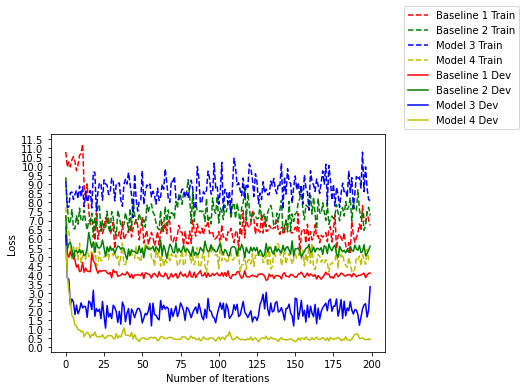

In [60]:
showPlot()

## 2.2 Data Statistics

In [66]:
# compute number of samples/recipes in each data set

training_sample_size = len(training_data)
dev_sample_size = len(dev_data)
test_sample_size = len(test_data)

print(training_sample_size, dev_sample_size, test_sample_size)

12939 112 82


In [65]:
train_input_ingredient, train_output_recipe, train_pairs = readRecipe(training_data)
dev_input_ingredient, dev_output_recipe, dev_pairs = readRecipe(dev_data)
test_input_ingredient, test_output_recipe, test_pairs = readRecipe(test_data)

In [67]:
print("Training vocabulary size (ingredient):" + " " + str(train_input_ingredient.n_words))
print("Dev vocabulary size (ingredient):" + " " + str(dev_input_ingredient.n_words))
print("Test vocabulary size (ingredient):" + " " + str(test_input_ingredient.n_words))

Training vocabulary size (ingredient): 6475
Dev vocabulary size (ingredient): 757
Test vocabulary size (ingredient): 645


In [68]:
print("Training vocabulary size (recipe):" + " " + str(train_output_recipe.n_words))
print("Dev vocabulary size (recipe):" + " " + str(dev_output_recipe.n_words))
print("Test vocabulary size (recipe):" + " " + str(test_output_recipe.n_words))

Training vocabulary size (recipe): 15469
Dev vocabulary size (recipe): 1502
Test vocabulary size (recipe): 1250


Helper function to compute average lengths of ingredients and recipes respectively.

In [71]:
def computelengths(pair_list):
  ing_list = []
  recipe_list = []
  total_ing = 0
  total_recipe_lines = 0

  for pair in pair_list:
    ing = pair[0].split(' ')
    ing_list.append(len(ing))

    total_ing += len(ing)

    recipe = pair[1].split('.')
    recipe_list.append(len(recipe))

    total_recipe_lines += len(recipe)

  max_ing_length = max(ing_list)
  max_recipe_length = max(recipe_list)

  avg_ing_length = total_ing/len(pair_list)
  avg_recipe_len = total_recipe_lines/len(pair_list)

  min_ing_length = min(ing_list)
  min_recipe_length = min(recipe_list)


  return max_ing_length, max_recipe_length, avg_ing_length, avg_recipe_len, min_ing_length, min_recipe_length

In [72]:
print(computelengths(train_pairs))
print(computelengths(dev_pairs))
print(computelengths(test_pairs))

(146, 63, 33.640466805780974, 10.206507458072494, 2, 1)
(120, 33, 32.017857142857146, 8.526785714285714, 3, 1)
(91, 29, 34.96341463414634, 9.829268292682928, 4, 2)
